In [1]:
import ROOT

Welcome to JupyROOT 6.20/04


pen the rootfile and get the workspace from the exercise_0

In [2]:
fInput = ROOT.TFile("Workspace_mumufit.root")
ws = fInput.Get("ws")
ws.Print()


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


RooWorkspace(ws) ws contents

variables
---------
(NJpsi,Nbkg,a1,a2,a3,alphaJpsi,cross_psi,eff_psi,lumi_psi,mass,meanJpsi,meanpsi2S,nJpsi,sigmaJpsi)

p.d.f.s
-------
RooCBShape::CBJpsi[ m=mass m0=meanJpsi sigma=sigmaJpsi alpha=alphaJpsi n=nJpsi ] = 0.012173
RooCBShape::CBpsi2S[ m=mass m0=meanpsi2S sigma=sigmaJpsi alpha=alphaJpsi n=nJpsi ] = 0.00289326
RooChebychev::backgroundPDF[ x=mass coefList=(a1,a2,a3) ] = 1.35122
RooAddPdf::totPDF[ NJpsi * CBJpsi + Npsi * CBpsi2S + Nbkg * backgroundPDF ] = 0.91405

functions
--------
RooFormulaVar::Npsi[ actualVars=(eff_psi,lumi_psi,cross_psi) formula="x[0]*x[1]*x[2]" ] = 5.72535

datasets
--------
RooDataSet::data(mass)



ou can set constant parameters that are known<br>
f you leave them floating, the fit procedure will determine their uncertainty

In [3]:
ws.var("meanJpsi").setConstant(1)
ws.var("sigmaJpsi").setConstant(1)
ws.var("alphaJpsi").setConstant(1)
ws.var("nJpsi").setConstant(1)
ws.var("NJpsi").setConstant(1)
ws.var("meanpsi2S").setConstant(1)
ws.var("Nbkg").setConstant(1)
ws.var("a1").setConstant(1)
ws.var("a2").setConstant(1)
ws.var("a3").setConstant(1)

reate a modifier to account for signal efficiency uncertainty

In [4]:
ws.factory("Gaussian::effConstrain(gSigEff[1.],ratioSigEff[1.,0.,3],0.1)")   #Gaussian with 10% uncertainty
ws.factory("SUM::totPDF_withscaling( prod(cross_psi,lumi_psi,eff_psi,ratioSigEff)*CBpsi2S , NJpsi*CBJpsi, Nbkg*backgroundPDF )") #Recreate the total PDF with the scaling
ws.factory("PROD::totPDF_withconstrain(totPDF_withscaling, effConstrain)")

<ROOT.RooProdPdf object ("totPDF_withconstrain") at 0x7fb18fe91000>

In [6]:
print ("##################################")
print ("Now printing the workspace with the additional constraints")
print ("##################################")
ws.Print()

##################################
Now printing the workspace with the additional constraints
##################################

RooWorkspace(ws) ws contents

variables
---------
(NJpsi,Nbkg,a1,a2,a3,alphaJpsi,cross_psi,eff_psi,gSigEff,lumi_psi,mass,meanJpsi,meanpsi2S,nJpsi,ratioSigEff,sigmaJpsi)

p.d.f.s
-------
RooCBShape::CBJpsi[ m=mass m0=meanJpsi sigma=sigmaJpsi alpha=alphaJpsi n=nJpsi ] = 0.012173
RooCBShape::CBpsi2S[ m=mass m0=meanpsi2S sigma=sigmaJpsi alpha=alphaJpsi n=nJpsi ] = 0.00289326
RooChebychev::backgroundPDF[ x=mass coefList=(a1,a2,a3) ] = 1.35122
RooGaussian::effConstrain[ x=gSigEff mean=ratioSigEff sigma=0.1 ] = 1
RooAddPdf::totPDF[ NJpsi * CBJpsi + Npsi * CBpsi2S + Nbkg * backgroundPDF ] = 0.91405
RooProdPdf::totPDF_withconstrain[ totPDF_withscaling * effConstrain ] = 0.91405
RooAddPdf::totPDF_withscaling[ totPDF_withscaling_1 * CBpsi2S + NJpsi * CBJpsi + Nbkg * backgroundPDF ] = 0.91405

functions
--------
RooFormulaVar::Npsi[ actualVars=(eff_psi,lumi_psi,cross_ps

et the model know what is the parameter of interest

In [7]:
cross_psi = ws.var("cross_psi")
cross_psi.setRange(4., 16.)  #this is mostly for plotting reasons
poi = ROOT.RooArgSet(cross_psi)

In [8]:
ratioSigEff = ws.var("ratioSigEff")
constrainedParams = ROOT.RooArgSet(ratioSigEff)

onfigure the model

In [9]:
model = ROOT.RooStats.ModelConfig()
model.SetWorkspace(ws)
model.SetPdf("totPDF_withconstrain")
model.SetParametersOfInterest(poi)
model.SetNuisanceParameters(constrainedParams)
model.SetObservables( ROOT.RooArgSet(ws.var("mass")) )
model.SetGlobalObservables( ROOT.RooArgSet(ws.var("gSigEff")) )

et confidence level

In [10]:
confidenceLevel = 0.68

uild the profile likelihood calculator

In [11]:
plc = ROOT.RooStats.ProfileLikelihoodCalculator(ws.data("data"), model)
plc.SetParameters(poi)
plc.SetConfidenceLevel(confidenceLevel)

et the interval

In [12]:
pl_Interval = plc.GetInterval()

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_totPDF_withconstrain_FOR_OBS_mass with 1 entries
[#1] INFO:Minization --  Including the following constraint terms in minimization: (effConstrain)
[#1] INFO:Minization -- The following global observables have been defined: (gSigEff)
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_totPDF_withconstrain_data_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (CBpsi2S,CBJpsi,backgroundPDF)
[#1

ow let's determine the Bayesian probability interval<br>
e could use the standard Bayesian Calculator, but this would be very slow for the integration<br>
o we profit of the Markov-Chain MC capabilities of RooStats to speed things up

In [13]:
mcmc = ROOT.RooStats.MCMCCalculator(ws.data("data") , model)
mcmc.SetConfidenceLevel(confidenceLevel)
mcmc.SetNumIters(20000)           #Metropolis-Hastings algorithm iterations
mcmc.SetNumBurnInSteps(100)       #first N steps to be ignored as burn-in
mcmc.SetLeftSideTailFraction(0.5) #for central interval

In [14]:
MCMC_interval = mcmc.GetInterval()

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- createNLL picked up cached consraints from workspace with 1 entries
[#1] INFO:Minization --  Including the following constraint terms in minimization: (effConstrain)
[#1] INFO:Minization -- The following global observables have been defined: (gSigEff)
Metropolis-Hastings progress: ....................................................................................................
[#1] INFO:Eval -- Proposal acceptance rate: 10.29%
[#1] INFO:Eval -- Number of steps in chain: 2058


et's make a plot

In [15]:
dataCanvas = ROOT.TCanvas("dataCanvas")
dataCanvas.Divide(2,1)

In [16]:
dataCanvas.cd(1)
plot_Interval = ROOT.RooStats.LikelihoodIntervalPlot(pl_Interval)
plot_Interval.SetTitle("Profile Likelihood Ratio")
plot_Interval.SetMaximum(3.)
plot_Interval.Draw()

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_totPDF_withconstrain_data_with_constr_Profile[cross_psi]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_totPDF_withconstrain_data_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_totPDF_withconstrain_data_with_constr_Profile[cross_psi]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_totPDF_withconstrain_data_with_constr_Profile[cross_psi]) minimum found at (cross_psi=11.9113)

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_totPDF_withconstrain_data_with_constr_Profile[cross_psi]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_totPDF_withconstrain_data_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_totPDF_withconstrain_data_with_constr_Prof

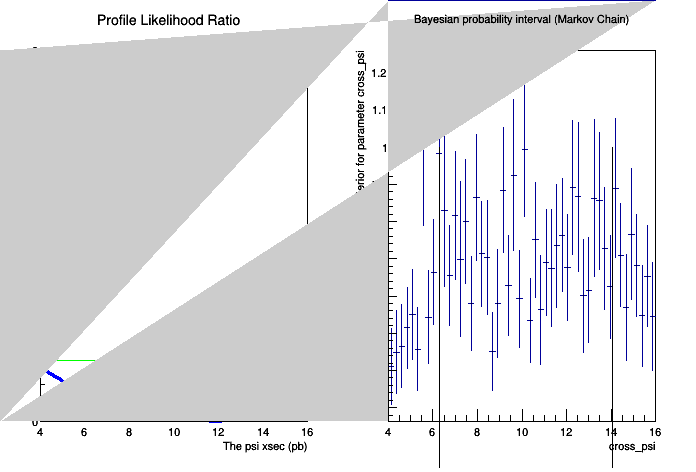

In [19]:
dataCanvas.cd(2)
plot_MCMC = ROOT.RooStats.MCMCIntervalPlot(MCMC_interval)
plot_MCMC.SetTitle("Bayesian probability interval (Markov Chain)")
plot_MCMC.Draw()
dataCanvas.Draw()

In [20]:
dataCanvas.SaveAs("exercise_5.png")

Info in <TCanvas::Print>: png file exercise_5.png has been created


ow print the interval for mH for the two methods

In [21]:
print ("PLC interval is [", pl_Interval.LowerLimit(cross_psi), ", ", pl_Interval.UpperLimit(cross_psi), "]")

PLC interval is [ 4.0 ,  16.0 ]


In [22]:
print ("Bayesian interval is [", MCMC_interval.LowerLimit(cross_psi), ", ", MCMC_interval.UpperLimit(cross_psi), "]")

Bayesian interval is [ 6.2765330709517 ,  14.049111584201455 ]


yROOT sometimes fails cleaning memory, this helps

In [23]:
del plc